In [1]:
push!(LOAD_PATH, "/home/jberez/Projects/BostonHousing/docker-parallel2")

using Gen
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using Serialization
using StatsBase
using BNN
using PyPlot

#include("docker-parallel2/NUTS.jl")
#include("docker-parallel2/RJNUTS.jl")
include("docker-parallel2/utils.jl")
include("docker-parallel2/proposals.jl")
include("docker-parallel2/LoadData.jl")
include("hmc_mod.jl");

In [131]:
#Network hyperparameters
k_real = 4 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 4 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Hyperprior Hyperparameters
αᵧ = 1 #Regression Noise Shape
βᵧ = 1 #Regression Noise Scale/Rate
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1#0.1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape
β₂ = 1*k_real#0.1*k_real; #Hidden & Output Weights Scale

#Bayesian Neural Network 

function G(x, trace)
    activation = relu
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
    
end;

#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Noise Variance
    τᵧ ~ gamma(αᵧ,βᵧ)
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    #Sy = Diagonal([σᵧ for i=1:length(x[1,:])])::Diagonal{<:Real}
    Sy = Diagonal([100 for i=1:length(x[1,:])])::Diagonal{<:Real}
    y = @trace(mvnormal(vec(scores), Sy), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

(best_trace,) = generate(interpolator,(x_train,),obs);
println(get_score(best_trace))

-1081.2214698758498


In [154]:
#HMC Attempt
include("NUTS3.jl")
@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

@gen function gibbs_noise(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    n = length(trace[:y])
    α = αᵧ + (n/2)
    
    x = get_args(trace)[1]
    y_pred = transpose(G(x,trace))[:,1]
    y_real = trace[:y]
    Σᵧ = sum((y_pred .- y_real).^2)/2
    β = 1/(1/βᵧ + Σᵧ)
    
    τ ~ gamma(α,β)
    obs_new[:τᵧ] = τ
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

M = 1
ϵ = 0.01
Δ_max = 1000

function within_move(trace)
    l = 1
    param_selection = select()
    
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    score1 = get_score(trace)
    #(new_trace, hmc_score) = hmc_mod(trace, param_selection, L=l, eps=ϵ, check=false, observations=obs)
    new_trace = NUTS(trace,param_selection,ϵ,1,false)[2]
    
    score2 = get_score(new_trace)
    #println("new trace score: $score2")
    #println("old trace score: $score1")
    
    hmc_score = score2 - score1
    
    if exp(hmc_score) == 1
        accepted = 0.0
        push!(within_acceptance, accepted)
        return trace
    end

    if rand(Uniform(0,1)) < exp(hmc_score)
        trace = new_trace
        accepted = 1.0
        #println("Accepted")
    else
        trace = trace
        accepted = 0.0
        #println("Not Accepted")
    end
    push!(within_acceptance, accepted)

    return trace
end

#traces = []
#scores = []
across_acceptance = []
within_acceptance = []
trace = best_trace

iters = 5000

for i=1:iters
    #(trace, accepted) = layer_parameter(trace)
    #push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    trace  = gibbs_noise(trace)
    trace  = within_move(trace)
    push!(scores,get_score(trace))
    push!(traces, trace)
    #println("Iter $i : $(get_score(trace))")
    if i%20 == 0
        #a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        #println("Chain $chain Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
    flush(stdout)
end

Epoch 20 W Acceptance Probability: 15.0 %


InterruptException: InterruptException:

In [153]:
best_trace = traces[length(traces)];

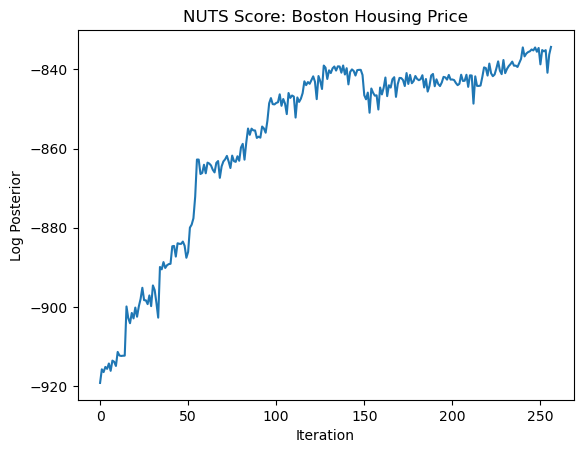

In [137]:
#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

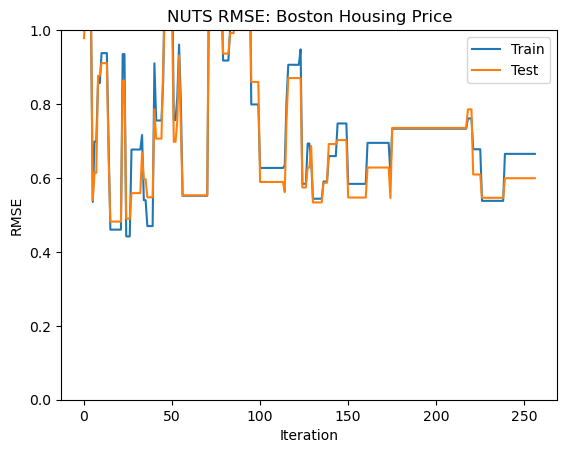

In [138]:
#-------------------------------
#Plot RMSE Train Scores by Trace
#-------------------------------

mses_train = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    mse = mse_scaled(pred_y,y_train)

    push!(mses_train,mse)
end

mses_test = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    mse = mse_scaled(pred_y,y_test)

    push!(mses_test,mse)
end

plot(mses_train,label="Train")
plot(mses_test, label="Test")
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylim(0,1)
plt.ylabel("RMSE");
plt.legend()

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [139]:
test_trace = traces[length(traces)-20]
pred_y = transpose(G(x_test,test_trace))[:,1]

253-element Array{Float64,1}:
 -0.5702573879030595
 -0.4632327075874402
 -0.5822137101084537
 -0.3645955707273506
  0.12907430805339698
 -0.05715867267356062
 -0.11933109161636545
 -0.14171524298078353
 -0.17693468915583077
 -0.07227114307976713
 -0.6076008730944292
 -0.45561267906677483
 -0.2010141444170182
  ⋮
 -0.014909128120284082
 -0.04862722830112137
 -0.04766838538302717
 -0.6197038542691455
 -0.7001681917880425
 -0.09701953571943729
 -0.10413112490085442
 -0.2728077716937879
 -0.11947939625085115
 -0.41795142010395836
 -0.8056078824054107
  0.07242158810891106

In [105]:
y_test

253-element Array{Float64,1}:
 -0.34062964758760134
 -1.3191985443286653
 -0.8951520224075376
 -1.2648336056208285
  2.551585091669322
 -0.025313003082147057
  1.1489696730071302
 -0.21015379468879244
  0.9750018691420519
 -0.1449158682393884
 -0.9168979978906724
 -0.9168979978906724
 -0.8407870836997006
  ⋮
 -0.22102678243036
 -0.2971376966213316
 -0.3949945862954382
 -0.37324861081230315
 -0.44935952500327514
 -0.12316989275625372
  0.07254388659195922
  2.9865046013320176
  0.9423829059173496
 -0.819041108216566
 -0.503724463711112
 -0.3515026353291685

In [106]:
y_pred2 = StatsBase.reconstruct(dy,pred_y)
y_real = StatsBase.reconstruct(dy,y_test)
√(sum((y_pred2 .- y_real).^2))/length(y_real)

0.4295765933437136

In [152]:
#----------------
#Marginalize RMSE
#----------------
j = 50
y_marginal = zeros(length(y_train))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

mse = mse_scaled(y_marginal, y_train)
println("Training Set Marginal RMSE: $mse")

j = 50
y_marginal = zeros(length(y_test))

pred_ys = []
for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    push!(pred_ys,pred_y)
    y_marginal += (pred_y/(length(traces)-j))
end


mse = mse_scaled(y_marginal, y_test)
println("Test Set Marginal RMSE: $mse")

Training Set Marginal RMSE: 0.584546780023879
Test Set Marginal RMSE: 0.5673270759626619


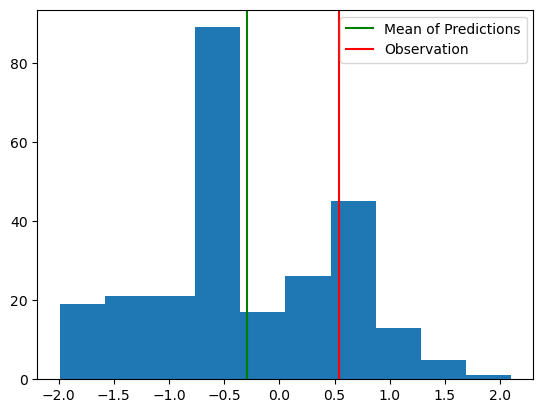

PyObject <matplotlib.legend.Legend object at 0x7f7f7dc48690>

In [148]:
test_iter = 33
predictions = [preds[test_iter] for preds in pred_ys]
hist(predictions)
plt.axvline(mean(predictions),c="green",label="Mean of Predictions")
plt.axvline(y_test[test_iter],c="red",label="Observation")
plt.legend()